In [ ]:
import numpy as np
import matplotlib.pyplot as plt
np.seterr(invalid='ignore')
from copy import deepcopy as cp

# Создание классов

Создадим класс для решения (Для красивого и удобного вывода)

## Класс решения

In [ ]:
class Solution:
  def __init__(self, solution, accuracy = None, wanted_accuracy = None, steps_count = None, var_names = None, max_iteration_count_reached = False, steps_info = None):
    self.solution = solution
    self.accuracy = accuracy
    self.wanted_accuracy = wanted_accuracy
    self.steps_count = steps_count
    self.var_names = var_names
    self.max_iteration_count_reached = max_iteration_count_reached
    self.steps_info = steps_info

  def __str__(self):
    s = "Result found"
    if (self.steps_count != None):
      s += f" in {self.steps_count} steps"
    if (self.accuracy != None):
      s += f" with accuracy {self.accuracy:.1e}"
    if (self.wanted_accuracy != None):
      s += f" ({self.wanted_accuracy:.0e} wanted)"
    if (self.max_iteration_count_reached):
      s += f" Required accuracy hasn't been achieved!"
    s += "\n"

    var_num = 1
    for res in self.solution:
      if self.var_names == None or len(self.var_names) < len(self.solution):
        s += f"x{var_num} = {res}\n"
      else:
        s += f"{self.var_names[var_num - 1]} = {res}\n"
      var_num += 1
    
    return s

  def steps(self):
    if self.steps_info == None:
      print("No steps info avaliable")
    else:
      for step in self.steps_info:
        print(step)

Создадим класс `EquationSystem`, который будет хранить в себе все необходимые параметры СНЛУ.

Так же в нем создадим функции `F(functions, X)` и `W(functions, X)`.

Первая будет составлять столбец значений функций для определенного столбца $X$.

Вторая будет считать Якобиан в точке $X$ методом численного дифференцирования.

Создадим функцию подсчета корней методом Ньютона.

## Класс СНЛУ

In [ ]:
class EquationSystem:

  def __init__(self):
    self.functions = []
    self.supposed_solutions = []

  def addFunction(self, *functions):
    self.functions += functions

  def addSupposedSolution(self, *solutions):
    self.supposed_solutions += solutions

  def setWantedAccuracy(self, wanted_accuracy):
    self.wanted_accuracy = wanted_accuracy

  def F(self, X):
    res = []
    for function in self.functions:
      #print(f"function {function.__name__}: {function(X)}")
      res.append(function(X))
    return np.array(res)

  @staticmethod
  def partial_derivative(function, var_num, X, step = 0.01):
    variation = np.zeros(len(X))
    variation[var_num] = step
    result = (function(X + variation) - function(X - variation)) / (2 * step)
    return result

  def W(self, X, step = 0.0001):
    W = []
    for function in self.functions:
      W_line = []
      for var_num in range(len(X)):
        W_line.append(self.partial_derivative(function, var_num, X, step))
      W.append(W_line)
    return np.array(W)

  @staticmethod
  def accuracy(X1, X2):
    return np.linalg.norm(X1-X2)

  def newton(self, max_steps_count = 20):
    solutions = []

    for solution in cp(self.supposed_solutions):
      too_many_steps_flag = False
      steps_info = []

      current_step = 0

      while current_step < max_steps_count:
        next_solution = solution - np.linalg.inv(self.W(solution)) @ self.F(solution)
        current_step += 1

        current_accuracy = self.accuracy(next_solution, solution)
        if current_accuracy <= self.wanted_accuracy:
          break

        if current_step >= max_steps_count:
          too_many_steps_flag = True

        solution = next_solution

        steps_info.append(f"Step {current_step}: {solution} (Accuracy {current_accuracy:.1e})")

      solutions.append(Solution(next_solution, accuracy = current_accuracy, wanted_accuracy = self.wanted_accuracy, steps_count = current_step,
                                var_names = ['x', 'y'], max_iteration_count_reached = too_many_steps_flag, steps_info = steps_info))

    return solutions

# Практическое задание IV.12.7

Выполним задание **12.7, пункт б)**

## Задание
Отыскать с точностью до $\varepsilon = 10^{-5}$ все точки пересечения следующих линий

$$
  (x - 1.4)^2 - (y - 0.6)^2 = 1
$$

$$
  4.2 x^2 + 8.8 y^2 = 1.42
$$

Создадим пустой объект системы уравнений

In [ ]:
system = EquationSystem()

## Задание функций

Приведем данные функции к виду $f(x, y) = 0$: 

$$
  f_1(x, y) = (x - 1.4)^2 - (y - 0.6)^2 - 1
$$

$$
  f_2(x, y) = 4.2 x^2 + 8.8 y^2 - 1.42
$$

Перегоним эти функции в методы Python и добавим в систему уравнений.

In [ ]:
def f1(X):
  x = X[0]
  y = X[1]
  return (x - 1.4)**2 - (y - 0.6)**2 - 1

def f2(X):
  x = X[0]
  y = X[1]
  return 4.2 * x**2 + 8.8 * y**2 - 1.42

system.addFunction(f1, f2)

## Установка точности

Так же установим необходимую для нас точность.

In [ ]:
system.setWantedAccuracy(1e-5)

## Оценка количества и положения корней

Теперь посмотрим на графике, сколько будет точек пересечения и где они примерно будут расположены. Для построения графика представим эти функции в явном виде. Так будет проще.

$$
  y_1 = \pm \sqrt{(x - 1.4)^2 - 1} + 0.6
$$

$$
  y_2 = \pm \sqrt{\frac{1.42 - 4.2 x^2}{8.8}}
$$

Теперь построим эти графики.

(-1.0, 1.0)

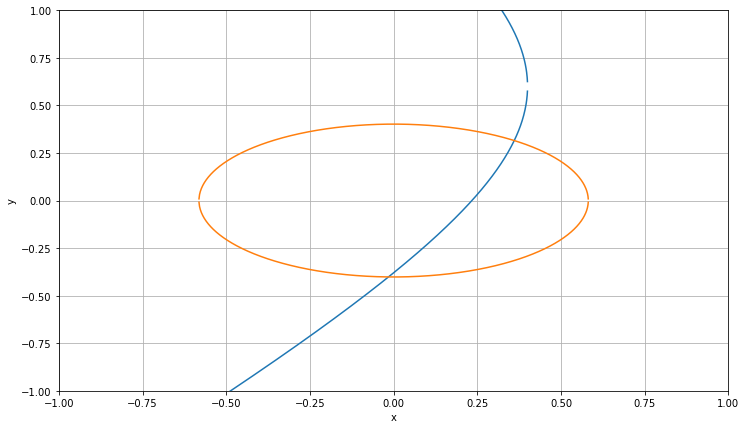

In [ ]:
def y1(x):
  return np.sqrt((x - 1.4)**2 - 1) + 0.6

def y2(x):
  return np.sqrt((1.42 - 4.2 * x**2) / 8.8)

plt.figure(figsize=[12,7])
plt.grid()
plt.xlabel('x')
plt.ylabel('y')

x = np.linspace(-2,2,5000)

plt.plot(np.hstack([x, x]), np.hstack([y1(x), -y1(x) + 1.2]))
plt.plot(np.hstack([x, x]), np.hstack([y2(x), -y2(x)]))
plt.xlim(-1, 1)
plt.ylim(-1, 1)

Игнорируем разрыв функции, так как он возникает из-за не особо грамотного метода построения графиков. _В следующий раз воспользуюсь `sympy`, чтобы было красиво._

Видно, что в наличии два пересечения линий:

$$
\begin{equation*}
 \begin{cases}
   x_1 \approx -0.05\\
   y_1 \approx -0.4
 \end{cases}
 \hspace{1cm}
 \begin{cases}
   x_2 \approx 0.3\\
   y_2 \approx 0.3
 \end{cases}
\end{equation*}
$$

Полученные предполагаемые точки пересечения так же занесем в систему.

In [ ]:
system.addSupposedSolution(np.array([-0.05, -0.4]), np.array([0.3, 0.3]))

## Решение методом Ньютона

Наконец, воспользуемся волшебством недавно созданного метода и получим решения данной системы уравнений.

Так же установим флаг `verbose`, чтобы пронаблюдать, что происходило со значениями на каждом шаге метода Ньютона.

In [ ]:
verbose = True

for solution in system.newton():
  if verbose:
    solution.steps()
  print(solution)

Step 1: [-0.01619307 -0.40222996] (Accuracy 3.4e-02)
Step 2: [-0.01531896 -0.4015625 ] (Accuracy 1.1e-03)
Result found in 3 steps with accuracy 1.3e-06 (1e-05 wanted)
x = -0.015318147459450142
y = -0.4015615101072784

Step 1: [0.35968921 0.31886045] (Accuracy 6.3e-02)
Step 2: [0.36027418 0.3153213 ] (Accuracy 3.6e-03)
Step 3: [0.36026429 0.31530658] (Accuracy 1.8e-05)
Result found in 4 steps with accuracy 3.7e-10 (1e-05 wanted)
x = 0.36026429080634204
y = 0.3153065772230789



# Практическое задание IV.12.2

Так же ради интереса можно проверить работу написанных классов на практическом задании **IV.12.2**

## Задание

$$
\begin{equation*}
 \begin{cases}
   tg(y-x) + xy = 0.3\\
   x^2 + y^2 = 1.5
 \end{cases}
\end{equation*}
$$

Найдем решения с точностью $\varepsilon = 10^{-6}$

In [ ]:
system = EquationSystem()

def f1(X):
  x = X[0]
  y = X[1]
  return np.tan(y - x) + x*y - 0.3

def f2(X):
  x = X[0]
  y = X[1]
  return x**2 + y**2 - 1.5

system.addFunction(f1, f2)
system.setWantedAccuracy(1e-6)

## Оценка количества и положения точек пересечения

В данном случае не будем мучиться с выражением функций в явном виде и воспользуемся читерскими возможностями библиотеки `sympy`

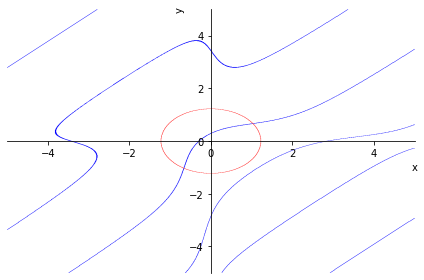

In [ ]:
import sympy

x, y = sympy.symbols('x y')
equation1 = sympy.Eq(sympy.tan(y - x) + x*y, 0.3)
equation2 = sympy.Eq(x**2 + y**2, 1.5)
plot1 = sympy.plot_implicit(equation1, line_color = 'b', show = False)
plot2 = sympy.plot_implicit(equation2, line_color = 'r', show = False)
plot1.extend(plot2)
plot1.show()

По этим прекрасным графикам можно понять, что точек пересечения всего две и они расположены примерно так:

$$
\begin{equation*}
 \begin{cases}
   x_1 \approx 1 \\
   y_1 \approx 0.5
 \end{cases}
 \hspace{1cm}
 \begin{cases}
   x_1 \approx -0.5 \\
   y_1 \approx -1
 \end{cases}
\end{equation*}
$$

Традиционно занесем их в новую систему

In [ ]:
system.addSupposedSolution(np.array([1, 0.5]), np.array([-0.5, -1]))

## Решение

In [ ]:
for solution in system.newton():
  solution.steps()
  print(solution)

Step 1: [1.04231599 0.66536802] (Accuracy 1.7e-01)
Step 2: [1.02948546 0.66357181] (Accuracy 1.3e-02)
Step 3: [1.02940586 0.66356882] (Accuracy 8.0e-05)
Result found in 4 steps with accuracy 3.3e-09 (1e-06 wanted)
x = 1.029405859537564
y = 0.6635688180963065

Step 1: [-0.66536802 -1.04231599] (Accuracy 1.7e-01)
Step 2: [-0.66357181 -1.02948546] (Accuracy 1.3e-02)
Step 3: [-0.66356882 -1.02940586] (Accuracy 8.0e-05)
Result found in 4 steps with accuracy 3.3e-09 (1e-06 wanted)
x = -0.6635688180963065
y = -1.029405859537564



Видим, что получены верные корни, а значит наши классы прекрасно работают и их можно еще-где нибудь использовать.

Кроме того, видно, что за достаточно малое количество шагов были получены верные решения с необходимой (даже большей, чем необходима) точностью. Правильность решений была проверена через WolframAlpha.